In [51]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt  # visualization

path = "../data/processed/"
# labeled = pd.read_csv(path + "20240406_Survival_Features_Labeled.csv").iloc[:, 1:]
labeled = pd.read_csv(path + "20240414_Survival_Features_Labeled.csv")  

In [55]:
labeled.columns

Index(['flag_restaurant_one_year', 'bin', 'camis', 'latitude', 'longitude',
       'open_year', 'close_year', 'years_open', 'food_100', 'food_400',
       'food_800', 'food_1000', 'bus_100', 'bus_400', 'bus_1000', 'train_100',
       'train_400', 'train_1000', 'office_area', 'retail_area',
       'residential_area', 'street_width_min', 'street_width_max',
       'posted_speed', 'dist_station', 'dist_park', 'dist_school',
       'office_450', 'retail_450', 'residential_450', 'ridership_morning_mean',
       'ridership_midday_mean', 'ridership_evening_mean',
       'ridership_night_mean', 'ridership_late_night_mean', 'idw_aadt_mean',
       'idw_atvc_mean'],
      dtype='object')

In [90]:
# feature selection
df = labeled[
    [
        "flag_restaurant_one_year",
        "food_100",
        "food_400",
        "food_800",
        "food_1000",
        "bus_100",
        "bus_400",
        "bus_1000",
        "train_100",
        "train_400",
        "train_1000",
        "office_area",
        "retail_area",
        "residential_area",
        "street_width_min",
        "street_width_max",
        # "betweeness",
        "dist_station",
        "dist_park",
        "dist_school",
        "office_450",
        "retail_450",
        "residential_450",
        "ridership_morning_mean",
        "ridership_midday_mean",
        "ridership_evening_mean",
        "ridership_night_mean",
        "ridership_late_night_mean",
        "idw_aadt_mean",
        "idw_atvc_mean",
    ]
].copy()

# df.isnull().sum()

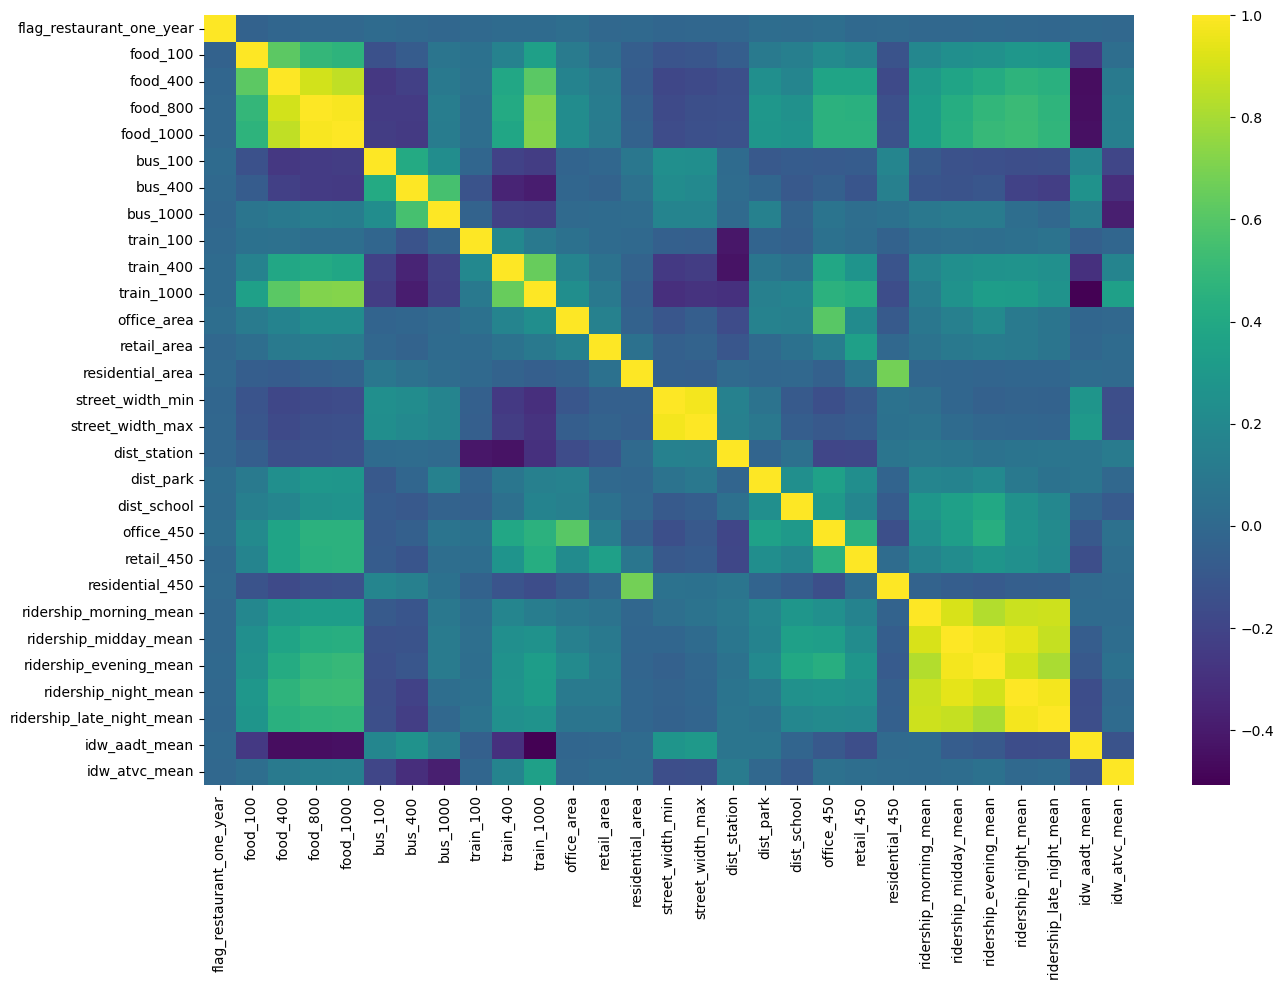

In [93]:
import seaborn as sns

# correlation matrix
corr = df.corr()
# mask = np.zeros_like(corr, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(15, 10))
sns.heatmap(
    corr,
    # mask=mask,
    # annot=True,
    fmt=".1f",
    # cmap="coolwarm",
    cmap="viridis",
    # cbar_kws={"shrink": 0.8},
)
plt.show()

In [57]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(
    df,
    test_size=0.3,
    random_state=42,
    stratify=df["flag_restaurant_one_year"],  # stratified sampling
)

X_train = train.drop("flag_restaurant_one_year", axis=1)
y_train = train["flag_restaurant_one_year"]
X_test = test.drop("flag_restaurant_one_year", axis=1)
y_test = test["flag_restaurant_one_year"]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# SMOTE for label imbalance
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train_resampled)

(2933, 28) (2933,) (1257, 28) (1257,)


In [58]:
# df["flag_restaurant_one_year"].value_counts()

In [59]:
# y_train_resampled.value_counts()

In [60]:
# xgboost clf
from xgboost import XGBClassifier

# accuracy score
from sklearn.metrics import accuracy_score


xgb = XGBClassifier(
    objective="binary:logistic",
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1,
    gamma=0,
    seed=27,
    nthread=4,
    verbosity=1,
    eval_metric="logloss",
)
xgb.fit(X_train_resampled, y_train_resampled)
y_train_pred = xgb.predict(X_train_resampled)
y_test_pred = xgb.predict(X_test)

# save model as pickle
import pickle

pickle.dump(xgb, open("xgb.pkl", "wb"))

In [70]:
# optimize with hyperopt
from hyperopt import hp, fmin, tpe, Trials, space_eval, STATUS_OK

space = {
    "n_estimators": hp.quniform("n_estimators", 100, 1000, 1),
    "max_depth": hp.quniform("max_depth", 3, 10, 1),
    "learning_rate": hp.quniform("learning_rate", 0.01, 0.3, 0.01),
    "min_child_weight": hp.quniform("min_child_weight", 1, 10, 1),
    "subsample": hp.quniform("subsample", 0.5, 1, 0.1),
    "colsample_bytree": hp.quniform("colsample_bytree", 0.5, 1, 0.1),
    "gamma": hp.quniform("gamma", 0, 0.5, 0.1),
    "scale_pos_weight": hp.quniform("scale_pos_weight", 1, 10, 1),
}


def objective(space):
    xgb = XGBClassifier(
        objective="binary:logistic",
        n_estimators=int(space["n_estimators"]),
        learning_rate=space["learning_rate"],
        max_depth=int(space["max_depth"]),
        min_child_weight=int(space["min_child_weight"]),
        subsample=space["subsample"],
        colsample_bytree=space["colsample_bytree"],
        scale_pos_weight=int(space["scale_pos_weight"]),
        gamma=space["gamma"],
        seed=27,
        nthread=4,
        verbosity=0,
        eval_metric="logloss",
    )
    xgb.fit(X_train_resampled, y_train_resampled)
    y_test_pred = xgb.predict(X_test)
    accuracy = accuracy_score(y_test, y_test_pred)
    return {"loss": -accuracy, "status": STATUS_OK}


trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

# best parameters
best_params = space_eval(space, best)
best_params

100%|██████████| 100/100 [00:31<00:00,  3.13trial/s, best loss: -0.5727923627684964]


{'colsample_bytree': 0.7000000000000001,
 'gamma': 0.4,
 'learning_rate': 0.13,
 'max_depth': 3.0,
 'min_child_weight': 8.0,
 'n_estimators': 490.0,
 'scale_pos_weight': 1.0,
 'subsample': 0.5}

In [74]:
# model with best parameters

xgb_best = XGBClassifier(
    objective="binary:logistic",
    n_estimators=int(best_params["n_estimators"]),
    learning_rate=best_params["learning_rate"],
    max_depth=int(best_params["max_depth"]),
    min_child_weight=int(best_params["min_child_weight"]),
    subsample=best_params["subsample"],
    colsample_bytree=best_params["colsample_bytree"],
    scale_pos_weight=int(best_params["scale_pos_weight"]),
    gamma=best_params["gamma"],
    seed=27,
    nthread=4,
    verbosity=0,
    eval_metric="logloss",
)
xgb_best.fit(X_train_resampled, y_train_resampled)
y_train_pred_best = xgb_best.predict(X_train_resampled)
y_test_pred_best = xgb_best.predict(X_test)

# save model as pickle
import pickle

pickle.dump(xgb, open("xgb_best.pkl", "wb"))

# accuracy for train and test sets
print(
    accuracy_score(y_train_resampled, y_train_pred_best),
    accuracy_score(y_test, y_test_pred_best),
)

0.8444022770398482 0.5727923627684964


In [75]:
test["flag_restaurant_one_year"].value_counts()

flag_restaurant_one_year
1    678
0    579
Name: count, dtype: int64

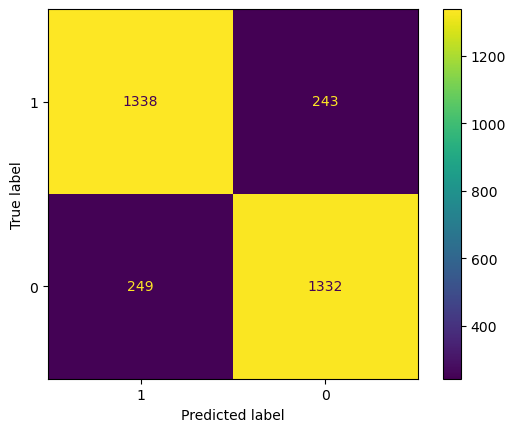

In [80]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_resampled, y_train_pred_best, labels=[1, 0])

# visualize confusion matrix

from sklearn import metrics

metrics.ConfusionMatrixDisplay(cm, display_labels=[1, 0]).plot()
plt.show()

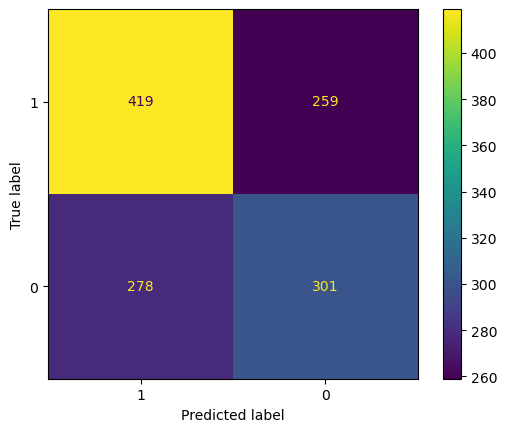

In [82]:
# visualize confusion matrix

from sklearn import metrics
cm = confusion_matrix(y_test, y_test_pred_best, labels=[1, 0])
metrics.ConfusionMatrixDisplay(cm, display_labels=[1, 0]).plot()
plt.show()

In [84]:
test["flag_restaurant_one_year"].value_counts()

flag_restaurant_one_year
1    678
0    579
Name: count, dtype: int64

In [83]:
# count each value
pd.DataFrame(y_test_pred_best).value_counts()

0
1    697
0    560
Name: count, dtype: int64

In [85]:
# classification report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_pred_best))

              precision    recall  f1-score   support

           0       0.54      0.52      0.53       579
           1       0.60      0.62      0.61       678

    accuracy                           0.57      1257
   macro avg       0.57      0.57      0.57      1257
weighted avg       0.57      0.57      0.57      1257



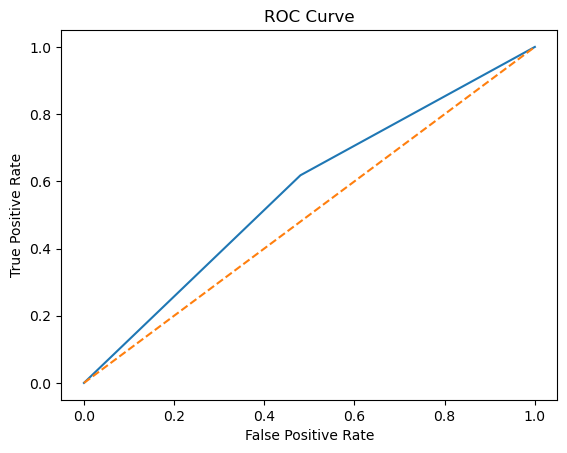

In [86]:
# auc-roc curve
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, y_test_pred_best)

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_best)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

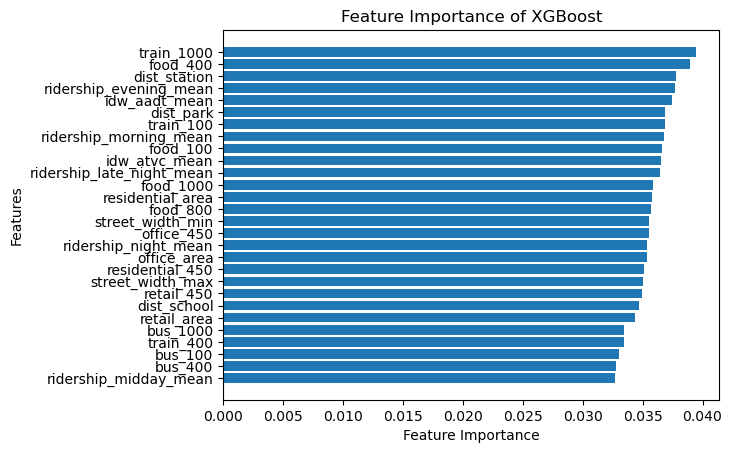

In [88]:
# feature importance

xgb.feature_importances_

# viz
# sorted

sorted_idx = xgb_best.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], xgb_best.feature_importances_[sorted_idx])

plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance of XGBoost")
plt.show()

In [89]:
labeled.groupby("flag_restaurant_one_year")["retail_area"].mean()

flag_restaurant_one_year
0    18513.302434
1    17262.522798
Name: retail_area, dtype: float64

In [32]:
test["y_pred"] = y_test_pred
test["y_pred_proba"] = xgb.predict_proba(X_test)[:, 1]

In [33]:
test[test["flag_restaurant_one_year"] != test["y_pred"]]

,flag_restaurant_one_year,food_100,food_400,food_800,food_1000,bus_100,bus_400,bus_1000,train_100,train_400,...,office_450,retail_450,residential_450,ridership_morning,ridership_midday,ridership_evening,ridership_night,ridership_late_night,y_pred,y_pred_proba
1129,0,67,332,1228,1765,1,12,46,0,4,...,5423724,493754,1220212,290.296012,589.012273,666.519516,248.617186,54.498754,1,0.999440
1620,1,32,406,1274,1799,0,4,40,0,4,...,7134357,2862562,80472,1415.491211,1254.442890,1236.241994,660.901682,192.167899,0,0.002994
1811,0,20,233,776,1303,0,1,35,0,4,...,1058559,372930,880192,634.917405,2097.682651,2468.804860,1273.981334,250.087224,1,0.999543
1792,0,14,180,657,970,0,15,46,0,0,...,2593677,207930,3051343,1810.792030,2680.708173,3561.011857,1072.856905,239.729224,1,0.513061
538,1,26,313,979,1171,0,6,36,1,2,...,120415,215704,664770,211.020783,674.358991,687.780976,295.261416,58.690629,0,0.304953
1451,0,30,303,1017,1475,0,4,50,1,2,...,4170384,204117,1065054,341.606646,1074.658679,1625.485960,460.167390,98.033250,1,0.523467
2218,0,35,241,872,1183,0,7,35,0,1,...,386769,149071,1828128,220.548232,498.985167,489.673656,326.712107,80.553843,1,0.999651
1798,1,30,316,1275,1896,0,7,51,0,2,...,8889233,470245,26026,179.763170,920.104462,1673.826310,568.525079,120.690942,0,0.227628
289,1,3,45,122,220,0,13,50,0,1,...,12212951,5350,1109704,102.496074,386.065015,451.199040,163.376203,23.575445,0,0.009897
320,0,21,347,1379,2161,0,9,37,1,2,...,11276990,867222,163721,127.440652,906.348567,1936.285786,542.646535,114.790861,1,0.999820


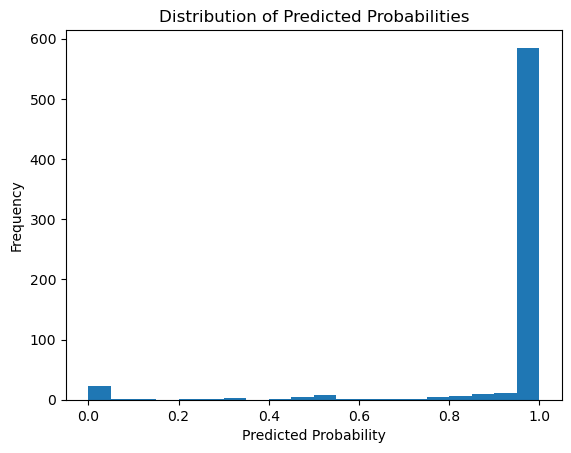

In [34]:
# distribution of predicted probabilities
plt.hist(test["y_pred_proba"], bins=20)
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Probabilities")
plt.show()

In [35]:
# Predict probabilities on the test set
y_proba = xgb.predict_proba(X_test)[:, 1]  # Probabilities for class 1 (positive class)

# Define a custom threshold
custom_threshold = 0.6

# Apply custom threshold to make predictions
y_pred_custom = (y_proba >= custom_threshold).astype(int)

In [36]:
# accuracy for train and test sets
print(
    accuracy_score(y_train_resampled, y_train_pred),
    accuracy_score(y_test, y_pred_custom),
)

0.9915311653116531 0.9417910447761194


In [37]:
cm = confusion_matrix(y_test, y_pred_custom, labels=[1, 0])
cm

array([[609,  25],
       [ 14,  22]])

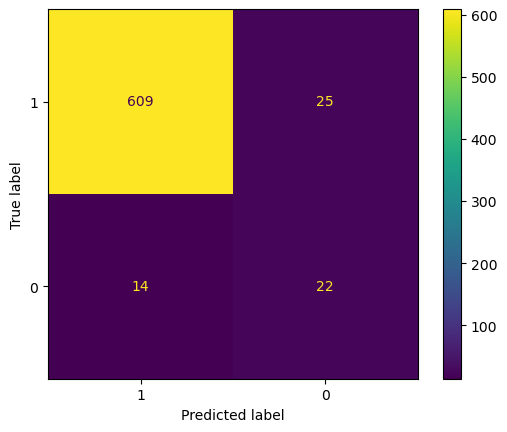

In [38]:
# visualize confusion matrix

from sklearn import metrics

metrics.ConfusionMatrixDisplay(cm, display_labels=[1, 0]).plot()
plt.show()

In [39]:
# classification report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_custom))

              precision    recall  f1-score   support

           0       0.47      0.61      0.53        36
           1       0.98      0.96      0.97       634

    accuracy                           0.94       670
   macro avg       0.72      0.79      0.75       670
weighted avg       0.95      0.94      0.95       670



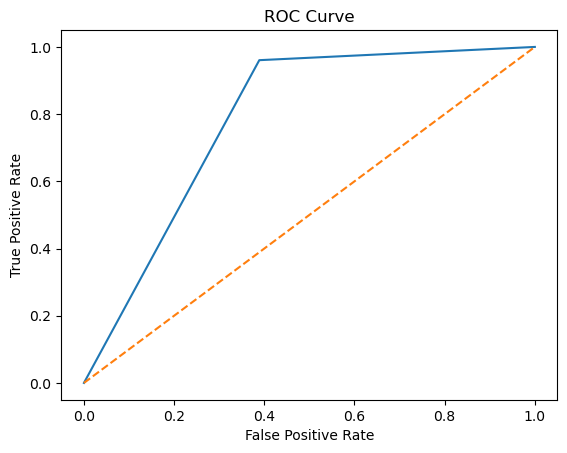

In [40]:
# auc-roc curve
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, y_test_pred)

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_custom)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()